In [1]:
import models
from contrastive import ContrastiveModel, ContrastiveModel_ori
import time
import numpy as np
import scipy.io as io
from scipy.interpolate import CubicSpline
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from matplotlib import pyplot as pt
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Loss functions and some useful tools:

- modified supcon loss

- original supcon loss

- ucr datasets reader

- data augmentation for supcon learning

- create augmentation pairs for SimCLR

- data validation


In [2]:
def supcon_loss(y_true, y_pred):
    temp = 1
    t = tf.cast(temp, tf.float32)
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    mask = tf.math.equal(y_true, tf.transpose(y_true))
    mask = tf.cast(mask, tf.float32)
    batch_size = tf.shape(mask)[0]
    remove = tf.eye(batch_size)
    mask = mask-remove
    num_pos = tf.reduce_sum(mask, axis=1)
    logits = tf.matmul(y_pred, y_pred, transpose_b=True)
    logits = logits/t
    logits = (logits - tf.reduce_max(tf.stop_gradient(logits), axis=1, keepdims=True))
    exp_logits = tf.exp(logits)
    d_mask = tf.ones((batch_size, batch_size))
    d_mask = d_mask-remove
    denominator = exp_logits*d_mask
    denominator = tf.reduce_sum(denominator, axis=1, keepdims=True)
    log_probs = (logits - tf.math.log(denominator))*mask
    log_probs = tf.reduce_sum(log_probs, axis=1)
    log_probs = tf.math.divide_no_nan(log_probs, num_pos)
    
    loss = -log_probs
    loss = loss*t
    return loss

def supcon_loss_ori(y_true, y_pred):
    temp = 1
    t = tf.cast(temp, tf.float32)
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    mask = tf.math.equal(y_true, tf.transpose(y_true))
    mask = tf.cast(mask, tf.float32)
    batch_size = tf.shape(y_pred)[0]
    num_views = tf.shape(y_pred)[1]
    mask = tf.tile(mask, [num_views, num_views])
    logits_mask = tf.ones_like(mask) - tf.eye(tf.shape(mask)[0])
    mask = mask*logits_mask
    
    y_pred = tf.reshape(tf.transpose(y_pred, perm=[1,0,2]), [batch_size*num_views, -1])
    
    num_pos = tf.reduce_sum(mask, axis=1)
    logits = tf.matmul(y_pred, y_pred, transpose_b=True)
    logits = logits/t
    logits = (logits - tf.reduce_max(tf.stop_gradient(logits), axis=1, keepdims=True))
    exp_logits = tf.exp(logits)

    denominator = exp_logits*logits_mask
    denominator = tf.reduce_sum(denominator, axis=1, keepdims=True)
    log_probs = (logits - tf.math.log(denominator))*mask
    log_probs = tf.reduce_sum(log_probs, axis=1)
    log_probs = tf.math.divide_no_nan(log_probs, num_pos)
    
    loss = -log_probs
    loss = loss*t
    loss = tf.reshape(loss, [num_views, batch_size])
    return tf.reduce_mean(loss, axis=0)

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(float)

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(
                np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), 
                window_steps, 
                pat[window_starts[i]:window_ends[i],dim]
            )
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

def jitter(x, sigma=0.05):
    return x + np.random.normal(0, sigma, size=(x.shape[0], x.shape[1]))

def scale(x, sigma=0.1):
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0], x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])


def permute(x, seg=2):
    if x.shape[1]%seg != 0:
        nb, n, t =x.shape[0], seg, int(x.shape[1]/seg)+1
        x_per = x[:, :int((seg-1)*t)]
        x_tail = x[:, int((seg-1)*t):]
        x_per = x_per.reshape(nb, n-1, t)
        idx = np.random.permutation(n)
        x_hat = x_per[:, idx[0], :] if idx[0] !=seg-1 else x_tail
        for i in idx[1:]:
            x_add = x_per[:, i, :] if i !=seg-1 else x_tail
            x_hat = np.concatenate((x_hat, x_add), axis=1)
        return x_hat.reshape(nb, x.shape[1])
    
    nb, n, t =x.shape[0], seg, int(x.shape[1]/seg)
    x_hat = x.reshape(nb, n, t)
    idx = np.random.permutation(n)
    x_hat = x_hat[:, idx, :]
    return x_hat.reshape(nb, int(n*t))

def augmentation(x, y, augs=None):
    idx = np.random.permutation(len(x))
    y = y[idx]
    num_aug = len(augs)
    
    if not augs:
        return np.expand_dims(x[idx], axis=-1), np.expand_dims(y[idx], axis=-1)
    
    if len(y.shape) <2:
        y = np.expand_dims(y, axis=-1)
        
    non = x
    jit = jitter(x)
    inv = x[:, ::-1]
    warp = window_warp(np.expand_dims(x, axis=-1))
    warp = np.squeeze(warp) + np.random.normal(0, 0.02, x.shape[1])
    scl = np.squeeze(scale(np.expand_dims(x, axis=-1)))
    pem = permute(x, 3)
    
    new_x = np.array([])
    new_y = np.array([])
    for func in augs:
        aug = locals()[func]
        aug = aug[idx]
        if len(new_x) == 0:
            new_x = aug
            new_y = y
        else:
            new_x = np.concatenate((new_x, aug), axis=-1)
            new_y = np.concatenate((new_y, y), axis=-1)
            
    n, d = new_x.shape
    new_x = np.reshape(new_x, [int(n)*num_aug, int(d/num_aug), 1])
    n, d = new_y.shape
    new_y = np.reshape(new_y, [int(n)*num_aug, int(d/num_aug)])
    return new_x, new_y

def create_pairs(x, y):
    new_x = []
    label = []
    c_label = []
    l = len(x[0])
    for i in range(len(x)):
        ts = x[i]
        ws = ts + np.random.normal(0, 0.03, x.shape[1])
        new_x += [ts]
        label += [i]
        c_label += [y[i]]
        new_x += [ws]
        label += [i]
        c_label += [y[i]]

    return np.array(new_x), np.array(label), np.array(c_label)

def valid(x):
    msk = np.isnan(x)
    x[msk] = np.interp(np.flatnonzero(msk), np.flatnonzero(~msk), x[~msk])
    return x

## Load dataset and preprocessing

In [3]:
x_train, y_train = readucr("data/UCRArchive_2018/Meat/Meat_TRAIN.tsv")
x_test, y_test = readucr("data/UCRArchive_2018/Meat/Meat_TEST.tsv")
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
'''
    -For special cases
'''
# a, b = np.unique(y_train)
# y_train[y_train==a]=0
# y_train[y_train==b]=1

# y_test[y_test==a] = 0
# y_test[y_test==b] = 1

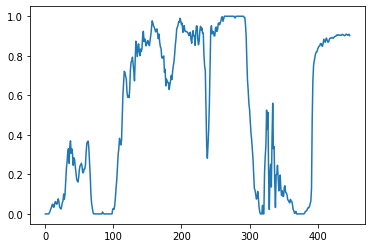

In [4]:
pt.plot(x_train[0])

In [5]:
if np.any(np.isnan(x_train)):
    x_train = valid(x_train)
    x_test = valid(x_test)
    print('data sets validated.')
else:
    print('valid data')

valid data


In [6]:
n_class = len(np.unique(y_test))

In [7]:
y_train -= np.unique(y_train)[0]
y_test -= np.unique(y_test)[0]

In [8]:
augs = ['pem', 'non']                                #augs = 'non', 'jit', 'pem', 'warp' or 'scl'
x_train, y_train = augmentation(x_train, y_train, augs)
num_views = len(augs)

In [ ]:
'''
    -SimCLR mode
    -Each pair is a class of its own
    -y_hat used for classification
    
'''
x_train, y_train, y_hat = create_pairs(x_train, y_train)

## Setup models

In [9]:
nb = 64
input_shape = x_train.shape[1:]
encoder = models.cautrans_enc(input_shape, head_size=256, num_heads=3, num_f=256, dilations=[1,4,16], k_size=4, dropout=0.3)
projector = models.projector(input_shape=encoder.output_shape[1:], mlp_units=[128], mlp_dropout=0.3)

## Modified SupCon Loss

#### TRAIN

In [10]:
model = ContrastiveModel(encoder = encoder, projector=projector)
model.compile(e_optimizer=Adam(), e_loss_fn=supcon_loss)
lr = ReduceLROnPlateau(monitor='e_loss', factor=0.5, patience=5, min_lr=0.00001)
stop = tf.keras.callbacks.EarlyStopping(monitor='e_loss', patience=10, restore_best_weights=True)

In [11]:
s = time.time()
model.fit(x_train, y_train, epochs = 200, batch_size=nb*num_views, callbacks=[lr])
e = time.time()

Epoch 1/200
1/1 [==============================] - 4s 4s/step - e_loss: 4.8664 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 110ms/step - e_loss: 5.0896 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 110ms/step - e_loss: 4.5659 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 111ms/step - e_loss: 4.4732 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 110ms/step - e_loss: 4.5276 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 0s 110ms/step - e_loss: 4.3954 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 0s 111ms/step - e_loss: 4.3582 - lr: 0.0010
Epoch 8/200
1/1 [==============================] - 0s 112ms/step - e_loss: 4.3990 - lr: 0.0010
Epoch 9/200
1/1 [==============================] - 0s 112ms/step - e_loss: 4.3311 - lr: 0.0010
Epoch 10/200
1/1 [==============================] - 0s 112ms/step - e_loss: 4.3036 - lr: 0.0010
Epoch 11/200
1/1 [==============================] - 

1/1 [==============================] - 0s 110ms/step - e_loss: 3.8115 - lr: 1.0000e-05
Epoch 166/200
1/1 [==============================] - 0s 110ms/step - e_loss: 3.8292 - lr: 1.0000e-05
Epoch 167/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8123 - lr: 1.0000e-05
Epoch 168/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8436 - lr: 1.0000e-05
Epoch 169/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.8524 - lr: 1.0000e-05
Epoch 170/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8177 - lr: 1.0000e-05
Epoch 171/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.8169 - lr: 1.0000e-05
Epoch 172/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8181 - lr: 1.0000e-05
Epoch 173/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8177 - lr: 1.0000e-05
Epoch 174/200
1/1 [==============================] - 0s 109ms/step - e_loss: 3.8091 - lr: 1.0000e-05
Epoc

In [189]:
e-s

26.868256092071533

#### TEST

In [12]:
tr_feat = model.encoder.predict(x_train)
te_feat = model.encoder.predict(x_test)
proj_tr = model.projector.predict(tr_feat)
proj_te = model.projector.predict(te_feat)

In [13]:
y_train = np.squeeze(y_train)
classifier = models.MLP_cl(input_dim=tr_feat.shape[1], mlp_layers=[256, 64], n_class=n_class)
classifier.compile(optimizer=Adam(learning_rate=1e-03), 
                   loss='sparse_categorical_crossentropy', 
                   metrics=["sparse_categorical_accuracy"]
                  )
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
classifier.fit(tr_feat, y_train, epochs=200, batch_size=64, validation_split=0.1, callbacks=callbacks)

Epoch 1/200
2/2 [==============================] - 0s 114ms/step - loss: 1.2652 - sparse_categorical_accuracy: 0.3889 - val_loss: 0.7823 - val_sparse_categorical_accuracy: 0.6667
Epoch 2/200
2/2 [==============================] - 0s 21ms/step - loss: 0.9094 - sparse_categorical_accuracy: 0.5556 - val_loss: 0.5490 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/200
2/2 [==============================] - 0s 24ms/step - loss: 0.6722 - sparse_categorical_accuracy: 0.7037 - val_loss: 0.4160 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/200
2/2 [==============================] - 0s 25ms/step - loss: 0.5211 - sparse_categorical_accuracy: 0.8611 - val_loss: 0.3339 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/200
2/2 [==============================] - 0s 24ms/step - loss: 0.4344 - sparse_categorical_accuracy: 0.8519 - val_loss: 0.2661 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/200
2/2 [==============================] - 0s 25ms/step - loss: 0.3587 - sparse_categorical_accuracy:

Epoch 47/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0111 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000
Epoch 48/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0133 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0015 - val_sparse_categorical_accuracy: 1.0000
Epoch 49/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0084 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0023 - val_sparse_categorical_accuracy: 1.0000
Epoch 50/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0070 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0043 - val_sparse_categorical_accuracy: 1.0000
Epoch 51/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0029 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0071 - val_sparse_categorical_accuracy: 1.0000
Epoch 52/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0127 - sparse_categorical_accu

In [14]:
classifier.evaluate(te_feat, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0772 - sparse_categorical_accuracy: 0.9667


[0.07722572237253189, 0.9666666388511658]

## Original SupCon Loss

#### TRAIN

In [15]:
model_ori = ContrastiveModel_ori(encoder = encoder, projector=projector)
model_ori.compile(e_optimizer=Adam(), e_loss_fn=supcon_loss_ori)
lr = ReduceLROnPlateau(monitor='e_loss', factor=0.5, patience=5, min_lr=0.00001)

In [16]:
n, t, d = x_train.shape
x_train_ori = np.reshape(x_train, [int(n/num_views), num_views, t, d])
y_train_ori = y_train.reshape([int(y_train.shape[0]/num_views), num_views])[:, 0]
y_train_ori = np.expand_dims(y_train_ori, axis=-1)
s = time.time()
model_ori.fit(x_train_ori, y_train_ori, epochs = 200, batch_size=nb, callbacks=[lr])
e = time.time()

Epoch 1/200
1/1 [==============================] - 1s 1s/step - e_loss: 3.8205 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8767 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.8594 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.8897 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.8120 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.8338 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8336 - lr: 0.0010
Epoch 8/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.8397 - lr: 0.0010
Epoch 9/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.8303 - lr: 0.0010
Epoch 10/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8417 - lr: 0.0010
Epoch 11/200
1/1 [==============================] - 

1/1 [==============================] - 0s 113ms/step - e_loss: 3.7963 - lr: 1.0000e-05
Epoch 165/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.7904 - lr: 1.0000e-05
Epoch 166/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8065 - lr: 1.0000e-05
Epoch 167/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.7940 - lr: 1.0000e-05
Epoch 168/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.7854 - lr: 1.0000e-05
Epoch 169/200
1/1 [==============================] - 0s 113ms/step - e_loss: 3.7881 - lr: 1.0000e-05
Epoch 170/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.7600 - lr: 1.0000e-05
Epoch 171/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.8063 - lr: 1.0000e-05
Epoch 172/200
1/1 [==============================] - 0s 112ms/step - e_loss: 3.7925 - lr: 1.0000e-05
Epoch 173/200
1/1 [==============================] - 0s 111ms/step - e_loss: 3.7973 - lr: 1.0000e-05
Epoc

In [175]:
e-s

28.424842834472656

#### TEST

In [17]:
tr_feat = model_ori.encoder.predict(x_train)
te_feat = model_ori.encoder.predict(x_test)
proj_tr = model_ori.projector.predict(tr_feat)
proj_te = model_ori.projector.predict(te_feat)

In [23]:
y_train = np.squeeze(y_train)
classifier = models.MLP_cl(input_dim=tr_feat.shape[1], mlp_layers=[256, 64], n_class=n_class)
classifier.compile(optimizer=Adam(learning_rate=1e-03), 
                   loss='sparse_categorical_crossentropy', 
                   metrics=["sparse_categorical_accuracy"]
                  )
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
classifier.fit(tr_feat, y_train, epochs=200, batch_size=64, validation_split=0.1, callbacks=callbacks)

Epoch 1/200
2/2 [==============================] - 0s 90ms/step - loss: 1.0635 - sparse_categorical_accuracy: 0.4352 - val_loss: 0.6749 - val_sparse_categorical_accuracy: 0.8333
Epoch 2/200
2/2 [==============================] - 0s 25ms/step - loss: 0.6827 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.4633 - val_sparse_categorical_accuracy: 0.8333
Epoch 3/200
2/2 [==============================] - 0s 24ms/step - loss: 0.5187 - sparse_categorical_accuracy: 0.8056 - val_loss: 0.3443 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.4506 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.2403 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/200
2/2 [==============================] - 0s 28ms/step - loss: 0.3395 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.1841 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.2681 - sparse_categorical_accuracy: 

Epoch 47/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0084 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0037 - val_sparse_categorical_accuracy: 1.0000
Epoch 48/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0059 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0021 - val_sparse_categorical_accuracy: 1.0000
Epoch 49/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0069 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_sparse_categorical_accuracy: 1.0000
Epoch 50/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0146 - sparse_categorical_accuracy: 1.0000 - val_loss: 6.3710e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 51/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0036 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.9708e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 52/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0084 - sparse_categori

In [24]:
classifier.evaluate(te_feat, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9667


[0.07047930359840393, 0.9666666388511658]

#### Visualization

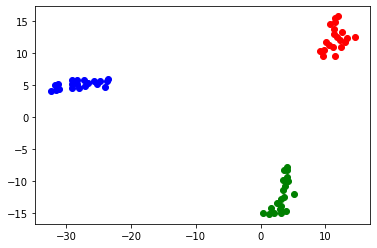

In [25]:
x_train = np.squeeze(x_train)
y_train = np.squeeze(y_train)
n_class = len(np.unique(y_train))
c = list(mcolors.BASE_COLORS.keys())
embed = TSNE(n_components=2, learning_rate=10, init = 'random', perplexity=10, n_iter=2000).fit_transform(proj_te)
# # pt.scatter(embed[:, 0], embed[:, 1], c=y_test)
for i in range(n_class):
    lab = y_test== i
    pt.scatter(embed[lab, 0], embed[lab, 1], color=c[i])

#### USC-HAD data Example

In [26]:
x = np.load('data/USC-HAD/usc_x_train.npy')

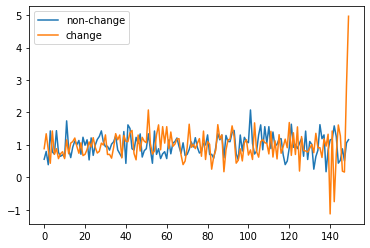

In [34]:
pt.plot(x[0], label='non-change')
pt.plot(x[150], label='change')
pt.legend()

#### ECochG data Example

In [15]:
x = np.load('data/ECochG/cm_tr_x.npy')

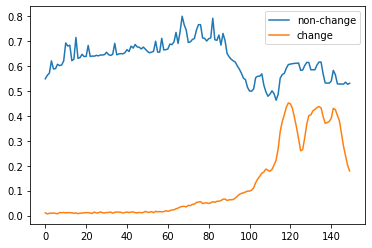

In [20]:
pt.plot(x[4081], label='non-change')
pt.plot(x[1999], label='change')
pt.legend()